In [2]:
import numpy as np
from os import PathLike
from pathlib import Path
import numpy as np
import moviepy.editor as mp

import cv2
import numpy as np
import torch
from PIL import Image
from numpy import linalg
from torch import nn
from torchvision import transforms, models
from helpers.kts import cpd_auto

In [31]:
change_points_array = []
pred_scores_array = []
summary_array = []
nfps_array = []

In [40]:
def custom_cps(specified_number, offset):
    change_points = []
    nfps = []
    start = 0
    while start < specified_number:
        if(start + offset > specified_number):
            end = specified_number
        else:
            end = start + offset
        change_points.append([start, end])
        start = end + 1
    for segment in change_points:
        nfps.append(segment[1] - segment[0] + 1)
    return np.array(change_points,dtype=np.int32), np.array(nfps,dtype=np.int32)

In [35]:


class FeatureExtractor(object):
    def __init__(self):
        self.preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.model = models.googlenet(weights = 'DEFAULT')
        self.model = nn.Sequential(*list(self.model.children())[:-2])
        self.model = self.model.cuda().eval()

    def run(self, img: np.ndarray) -> np.ndarray:
        img = Image.fromarray(img)
        img = self.preprocess(img)
        batch = img.unsqueeze(0)
        with torch.no_grad():
            feat = self.model(batch.cuda())
            feat = feat.squeeze().cpu().numpy()

        assert feat.shape == (1024,), f'Invalid feature shape {feat.shape}: expected 1024'
        #normalize frame features
        #no norm
        feat /= linalg.norm(feat) + 1e-10
        return feat


class VideoPreprocessor(object):
    def __init__(self, sample_rate: int) -> None:
        self.model = FeatureExtractor()
        self.sample_rate = sample_rate

    def get_features(self, video_path: PathLike):
        video_path = Path(video_path)
        cap = cv2.VideoCapture(str(video_path))
        assert cap is not None, f'Cannot open video: {video_path}'

        features = []
        n_frames = 0

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            if n_frames % self.sample_rate == 0:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                feat = self.model.run(frame)
                features.append(feat)

            n_frames += 1

        cap.release()

        features = np.array(features)
        return n_frames, features

    def kts(self, n_frames, features):
        seq_len = len(features)
        picks = np.arange(0, seq_len) * self.sample_rate
        kernel = np.matmul(features, features.T)
        change_points, _ = cpd_auto(kernel, seq_len - 1, 1, verbose=False)
        change_points *= self.sample_rate
        change_points = np.hstack((0, change_points, n_frames))
        begin_frames = change_points[:-1]
        end_frames = change_points[1:]
        change_points = np.vstack((begin_frames, end_frames - 1)).T
        n_frame_per_seg = end_frames - begin_frames
        return change_points, n_frame_per_seg, picks

    def run(self, video_path: PathLike):
        n_frames, features = self.get_features(video_path)
        cps, nfps, picks = self.kts(n_frames, features)
        return n_frames, features, cps, nfps, picks

In [41]:
import os
import cv2
import torch
import numpy as np
from savedModel.model import VideoSummarizerNetwork
from helpers.VideoProccessor import VideoPreprocessor, write_video_summary ,combine_video_audio
from helpers.AudioProccessor import write_audio_summary
from helpers.vsum_helper import get_keyshot_summ
import json


num_feature = 1024
num_hidden = 128
num_head = 8
device = "cuda"
learning_rate = 5e-5
weight_decay = 1e-5
num_epoch = 300



def summarizeVideo(video_path, video_name,model_path):

    video_name = os.path.splitext(video_name)[0]

    print('Loading model ...')
    model = VideoSummarizerNetwork(num_feature=num_feature, num_hidden=num_hidden, num_head=num_head)
    model = model.eval().to("cpu")
    state_dict = torch.load(model_path,map_location=lambda storage, loc: storage)
    model.load_state_dict(state_dict)

    print('Preprocessing video ...')
    video_proc = VideoPreprocessor(15)
    n_frames, seq, cps, nfps, picks = video_proc.run(video_path)

    nfps_array = nfps

    n_s,_ = cps.shape
    if n_s < 3:
        print('Too few segments, using custom segments ...')
        cps,nfps  = custom_cps(n_frames, 300)


    change_points_array = cps


    print('Predicting summary ...')
    with torch.no_grad():
        seq_torch = torch.from_numpy(seq).unsqueeze(0).to("cpu")

        pred_cls = model.predict(seq_torch)

        pred_summ = get_keyshot_summ(pred_cls, cps, n_frames, nfps, picks)

    pred_scores_array = pred_cls
    summary_array = pred_summ

    return change_points_array, pred_scores_array, summary_array,nfps_array


In [10]:
import cv2

# Open the video file
video_capture = cv2.VideoCapture('d.mp4')  #Change 'your_video_file.mp4' to your video file path
# Get the frame rate
frame_rate = video_capture.get(cv2.CAP_PROP_FRAME_COUNT)
print(frame_rate)



6821.0


In [9]:
6912-6821

91

In [42]:
cps,pa,sa,nfpss = summarizeVideo("1711145751683.mp4", "1711145751683.mp4","savedModel/Attention-last0.pt")

Loading model ...
Preprocessing video ...
Predicting summary ...


In [39]:
print(cps)
print(nfpss)

print(5069 - 0)
print(6820 - 5070)

[[   0 5069]
 [5070 6820]]
[5070 1751]
5069
1750


In [28]:
print(cps)


# begin_frames = cps[:-1]
# end_frames = cps[1:]
# print(begin_frames)


# change_points = np.vstack((begin_frames, end_frames - 1)).T
# n_frame_per_seg = end_frames - begin_frames


[[   0  200]
 [ 201  401]
 [ 402  602]
 [ 603  803]
 [ 804 1004]
 [1005 1205]
 [1206 1406]
 [1407 1607]
 [1608 1808]
 [1809 2009]
 [2010 2210]
 [2211 2411]
 [2412 2612]
 [2613 2813]
 [2814 3014]
 [3015 3215]
 [3216 3416]
 [3417 3617]
 [3618 3818]
 [3819 4019]
 [4020 4220]
 [4221 4421]
 [4422 4622]
 [4623 4823]
 [4824 5024]
 [5025 5225]
 [5226 5426]
 [5427 5627]
 [5628 5828]
 [5829 6029]
 [6030 6230]
 [6231 6431]
 [6432 6632]
 [6633 6821]]
Frames in segment: 201
Frames in segment: 201
Frames in segment: 201
Frames in segment: 201
Frames in segment: 201
Frames in segment: 201
Frames in segment: 201
Frames in segment: 201
Frames in segment: 201
Frames in segment: 201
Frames in segment: 201
Frames in segment: 201
Frames in segment: 201
Frames in segment: 201
Frames in segment: 201
Frames in segment: 201
Frames in segment: 201
Frames in segment: 201
Frames in segment: 201
Frames in segment: 201
Frames in segment: 201
Frames in segment: 201
Frames in segment: 201
Frames in segment: 201
Frame

In [43]:
pa

array([0.30500528, 0.33886302, 0.28712022, 0.29726562, 0.29576206,
       0.30101356, 0.29516575, 0.2980608 , 0.31766668, 0.30273458,
       0.31049982, 0.30634764, 0.29051906, 0.27509257, 0.2951989 ,
       0.28734463, 0.27097696, 0.28360862, 0.2821782 , 0.2903138 ,
       0.25372502, 0.2695761 , 0.27984187, 0.26318082, 0.2806511 ,
       0.28964907, 0.2867403 , 0.28963524, 0.3101076 , 0.3079169 ,
       0.32278025, 0.31627235, 0.3204316 , 0.31884256, 0.33597597,
       0.31748143, 0.30839384, 0.31107548, 0.31565133, 0.30398175,
       0.30065942, 0.30241168, 0.3056145 , 0.3185662 , 0.27919495,
       0.3114668 , 0.2998692 , 0.27796772, 0.27495795, 0.2956488 ,
       0.3056896 , 0.30629322, 0.29992378, 0.3052786 , 0.30581045,
       0.31392884, 0.2982837 , 0.27985713, 0.28430185, 0.28237334,
       0.30674222, 0.30898798, 0.29863802, 0.27936396, 0.29128358,
       0.29488873, 0.30483067, 0.29143244, 0.30010775, 0.30052185,
       0.31739408, 0.3106485 , 0.32536873, 0.28482687, 0.31410

In [53]:
with open('sa_array.json', 'w') as f:
    json.dump(sa.tolist(), f)


(455,)
(6821,)


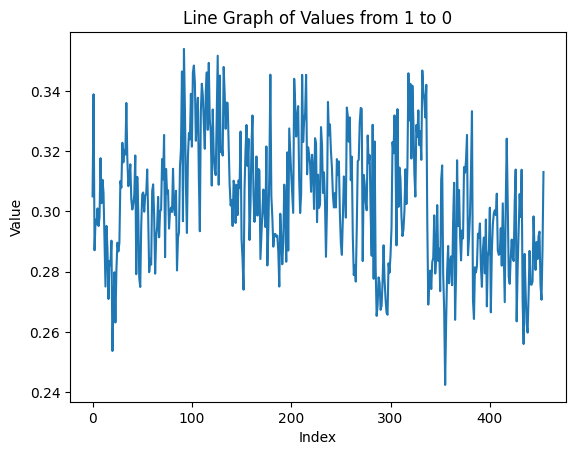

In [45]:
import matplotlib.pyplot as plt
import numpy as np

print(pa.shape)
print(sa.shape)

# Plot the values on a line graph
plt.plot(pa)

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Line Graph of Values from 1 to 0')


# Display the plot
plt.show()